In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch_geometric_temporal
import matplotlib.pyplot as plt
import torch.nn as nn
import random
import geopandas as gpd
import pyarrow


print(torch.cuda.is_available())       
print(torch.version.cuda)               
print(torch.cuda.get_device_name(0))    

from torch_geometric.data import Data
from torch_geometric_temporal.signal import DynamicGraphStaticSignal
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
from climate_features import ClimateConfig, compute_node_climate_by_bin
from pyproj import Transformer

True
12.1
NVIDIA GeForce GTX 960M


In [ ]:
BASE_DIR = 'D:/Desktop/mobility-seoul/'  # Change this to your base directory!

USE_CLIMATE_FEATURES = True
USE_URBAN_FEATURES = True
USING_INTERSECTION_NODE_TYPE = True

# __Importing Node and Link Data__

In [ ]:
nodes_df = pd.read_csv(os.path.join(BASE_DIR, 'graph_components/graph_components_intersections/node_urban_features.csv'), header = 0)
positions_links_df = pd.read_csv(os.path.join(BASE_DIR, 'graph_components/graph_components_intersections/positions_links_detailed.csv'), header = 0)

In [234]:
# making sure that there are no gaps in node IDs
original_ids = sorted(nodes_df["node_id"].unique())
id_map = {original_id: new_id for new_id, original_id in enumerate(original_ids)}


nodes_df["node_id_original"] = nodes_df["node_id"]
nodes_df["node_id"] = nodes_df["node_id"].map(id_map)

positions_links_df["node_id"] = positions_links_df["node_id"].map(id_map)
positions_links_df["prev_node_id"] = positions_links_df["prev_node_id"].map(id_map)

In [235]:
#-- adjusting some of the imported fields --

# dropping the geometry column
if 'geometry' in nodes_df.columns:
    nodes_df.drop(columns=['geometry'], inplace=True) 

for col in nodes_df.select_dtypes(include=['bool']).columns: # converting boolean columnkks to integers
    nodes_df[col] = nodes_df[col].astype(int)

# converting time stamps to datetime
positions_links_df["timestamp"] = pd.to_datetime(positions_links_df["merged_datetime"], format='ISO8601')                                                   
positions_links_df["merged_datetime"] = pd.to_datetime(positions_links_df['merged_datetime'], format='ISO8601').astype(int) // 10**9

# making sure ids are integers
positions_links_df['id_participant'].astype(int)
positions_links_df["node_id"] = positions_links_df["node_id"].astype(int)
positions_links_df["prev_node_id"] = positions_links_df["prev_node_id"].astype(int)
positions_links_df["id_participant"] = positions_links_df["id_participant"].astype(int)

# making the ids start from 0
if positions_links_df["id_participant"].min() > 0:
    positions_links_df["id_participant"] = positions_links_df["id_participant"] - 1

In [236]:
# adding day and week time fields 
positions_links_df["hour_of_day"] = positions_links_df["timestamp"].dt.hour
positions_links_df["day_of_week"] = positions_links_df["day_of_week"] = positions_links_df["timestamp"].dt.dayofweek  # Monday=0 ... Sunday=6

<Axes: xlabel='hour_of_day'>

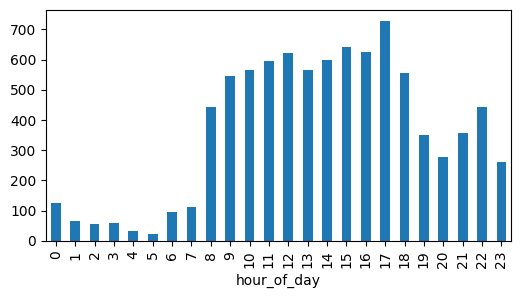

In [237]:
# plot number of records per hour
hourly_counts = positions_links_df["hour_of_day"].value_counts().sort_index()
hourly_counts.plot(kind="bar", figsize=(6, 3))

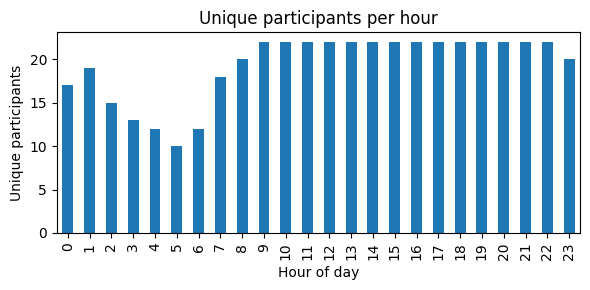

In [238]:

hourly_unique = positions_links_df.groupby("hour_of_day")["id_participant"].nunique()
plt.figure(figsize=(6,3))
hourly_unique.plot(kind="bar")
plt.xlabel("Hour of day")
plt.ylabel("Unique participants")
plt.title("Unique participants per hour")
plt.tight_layout()
plt.show()

<Axes: xlabel='day_of_week'>

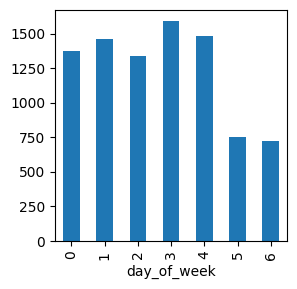

In [239]:
hourly_counts = positions_links_df["day_of_week"].value_counts().sort_index()
hourly_counts.plot(kind="bar", figsize=(3, 3))

In [240]:
use_weekdays_only = True   # <--- flip True/False as needed
remove_night_hours = True  # <--- flip True/False as needed

if use_weekdays_only:
    positions_links_df = positions_links_df[positions_links_df["day_of_week"] <= 4]  # keep Mon–Fri only

if remove_night_hours:
    positions_links_df = positions_links_df[positions_links_df["hour_of_day"].between(8, 23)]

<Axes: xlabel='hour_of_day'>

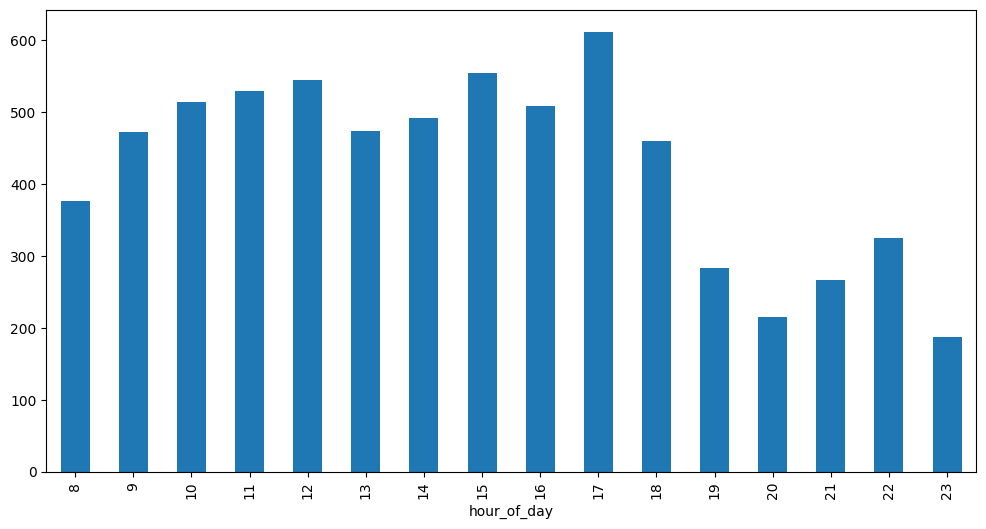

In [241]:
hourly_counts = positions_links_df["hour_of_day"].value_counts().sort_index()
hourly_counts.plot(kind="bar", figsize=(12, 6))

In [242]:
# filtering the data to only include days with at least 10 active participants
positions_links_df["timestamp"] = pd.to_datetime(positions_links_df["timestamp"], utc=True).dt.tz_convert("Asia/Seoul")
positions_links_df["day"] = positions_links_df["timestamp"].dt.floor("D")
participant_counts_per_day = positions_links_df.groupby("day")["id_participant"].nunique()

active_days = participant_counts_per_day[participant_counts_per_day >= 10].index
excluded_days = participant_counts_per_day[participant_counts_per_day < 10].index
positions_links_df = positions_links_df[positions_links_df["day"].isin(active_days)]

print(f"Excluded days with fewer than 10 participants ({len(excluded_days)} days):")
for day in excluded_days:
    print(day.strftime('%Y-%m-%d'))

Excluded days with fewer than 10 participants (7 days):
2023-10-04
2023-10-05
2023-10-09
2023-11-21
2023-11-22
2023-11-23
2023-11-24


In [243]:
# --- Drop bad date ranges (incompatible with climate dataset) ---
ts = positions_links_df["timestamp"]

# 23-10-2023 for the whole day
bad_23 = (ts >= pd.Timestamp("2023-10-23 00:00:00", tz="Asia/Seoul")) & \
         (ts <  pd.Timestamp("2023-10-24 00:00:00", tz="Asia/Seoul"))

# 24-10-2023 from 00:00 up to (but not including) 08:00
bad_24_early = (ts >= pd.Timestamp("2023-10-24 00:00:00", tz="Asia/Seoul")) & \
               (ts <  pd.Timestamp("2023-10-24 08:00:00", tz="Asia/Seoul"))

to_drop = bad_23 | bad_24_early
print(f"Dropping {to_drop.sum()} rows on 2023-10-23 (all day) and 2023-10-24 00:00–08:00.")
positions_links_df = positions_links_df.loc[~to_drop].copy()

Dropping 205 rows on 2023-10-23 (all day) and 2023-10-24 00:00–08:00.


### Additional Preprocessing on Data (Stays, )

In [244]:
# || Average time between records for each participant ||

positions_links_df = positions_links_df.sort_values(["id_participant", "timestamp"]) # ensuring timestamp is sorted for each participant

# Compute time differences for each participant
positions_links_df["time_diff"] = positions_links_df.groupby("id_participant")["timestamp"].diff().dt.total_seconds()

# overall mean and median time differences
overall_mean = positions_links_df["time_diff"].mean(skipna=True)
overall_median = positions_links_df["time_diff"].median(skipna=True)



# weekdays 09:00–18:00 only 
mask = (positions_links_df["hour_of_day"] >= 9) & (positions_links_df["hour_of_day"] < 18) & (positions_links_df["day_of_week"] <= 4)
filtered_df = positions_links_df[mask]

filtered_df = filtered_df.sort_values(["id_participant", "timestamp"])
filtered_df["time_diff"] = filtered_df.groupby("id_participant")["timestamp"].diff().dt.total_seconds()

filtered_mean = filtered_df["time_diff"].mean(skipna=True)
filtered_median = filtered_df["time_diff"].median(skipna=True)

print("Overall:")
print(f"   Mean time difference:   {overall_mean:.2f} seconds")
print(f"   Median time difference: {overall_median:.2f} seconds")

print("\nWeekdays (09:00–18:00):")
print(f"   Mean time difference:   {filtered_mean:.2f} seconds")
print(f"   Median time difference: {filtered_median:.2f} seconds")

Overall:
   Mean time difference:   11796.31 seconds
   Median time difference: 2391.09 seconds

Weekdays (09:00–18:00):
   Mean time difference:   17149.42 seconds
   Median time difference: 3285.77 seconds


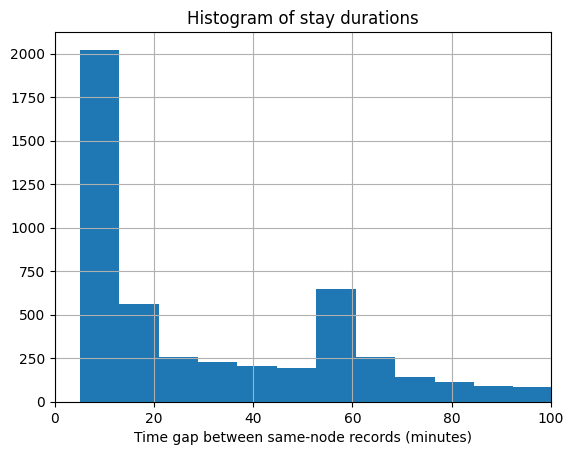

Removed 259 redundant stays.
Total rows before filtering: 6328
Total rows after filtering: 6069

Added 12741 new rows for static positions.
Total rows before interpolation: 6069
Total rows after interpolation: 18810
Difference: 12741


In [245]:
# || 'STAYS' ||

'''
if a participant stays at the same node for more than a certain interval, we will remove intermediate records
this is to ensure that data about people staying at the same node is consistent for all stays
'''

# visualizing stays
gaps = []
for pid, group in positions_links_df.groupby("id_participant"):
    group = group.sort_values("merged_datetime")
    stays = group[group["node_id"] == group["node_id"].shift()]
    delta = group["merged_datetime"].diff()
    gaps.extend(delta.dropna().values)

plt.hist(np.array(gaps) / 60, bins=1000)
plt.xlim(0, 100)
plt.xlabel("Time gap between same-node records (minutes)")
plt.title("Histogram of stay durations")
plt.grid()
plt.show()

# removing intermediate records of participants at the same node tbat are closer than the interval

interval_stays = 60*30    # 30 minutes
def filter_redundant_stays(df, interval_sec):
    filtered_rows = []
    for pid, group in df.groupby("id_participant"):
        group = group.sort_values("merged_datetime")
        prev_node = None
        prev_time = None
        prev_row = None

        for i, row in group.iterrows():
            current_node = row["node_id"]
            current_time = row["merged_datetime"]

            if prev_node is None:
                filtered_rows.append(row)
                prev_time = current_time
                prev_node = current_node
                prev_row = row
                continue

            if current_node != prev_node:
                # ensuring last row at old node is saved
                if prev_row is not None and filtered_rows[-1]["merged_datetime"] != prev_row["merged_datetime"]:
                    filtered_rows.append(prev_row)
                # always adding first row at new node
                filtered_rows.append(row)
                prev_time = current_time

            elif (current_time - prev_time) >= interval_sec:
                # if the time difference is greater than the interval, add the row
                filtered_rows.append(row)
                prev_time = current_time

            prev_node = current_node
            prev_row = row
            
    print(f"Removed {len(df) - len(filtered_rows)} redundant stays.")
    print(f"Total rows before filtering: {len(df)}")
    print(f"Total rows after filtering: {len(filtered_rows)}")
    return pd.DataFrame(filtered_rows).sort_values(by="merged_datetime").reset_index(drop=True)

# adding new rows between stays to make it more consistent
def interpolate_static_positions(df, interval_sec):
    interpolated_rows = []
    new_count = 0

    for pid, group in df.groupby("id_participant"):
        group = group.sort_values("merged_datetime")
        prev_row = None

        for _, row in group.iterrows():
            if prev_row is None:
                interpolated_rows.append(row)
                prev_row = row
                continue

            same_node = row["node_id"] == prev_row["node_id"]
            t0 = prev_row["merged_datetime"]
            t1 = row["merged_datetime"]
            duration = t1 - t0

            if not same_node or duration <= interval_sec:           # rows where nothing is done
                interpolated_rows.append(row)
                prev_row = row
                continue

            n_steps = max(1, round(duration / interval_sec))

            for i in range(1, n_steps):
                frac = i / n_steps
                new_row = prev_row.copy()
                new_time = int(t0 + frac * (t1 - t0))
                new_row["merged_datetime"] = new_time
                new_row["timestamp"] = pd.to_datetime(new_time, unit='s').tz_localize("UTC").tz_convert("Asia/Seoul")
                new_row['hour_of_day'] = new_row["timestamp"].hour
                new_row['day_of_week'] = new_row["timestamp"].dayofweek
                new_row["day"] = new_row["timestamp"].floor("D")
                new_row["speed"] = 0
                new_row['interpolated'] = True
                #print(new_row["timestamp"])
                interpolated_rows.append(new_row)
                new_count += 1

            interpolated_rows.append(row)
            prev_row = row
            
    print(f"\nAdded {new_count} new rows for static positions.")
    print(f"Total rows before interpolation: {len(df)}")
    print(f"Total rows after interpolation: {len(interpolated_rows)}")
    print(f"Difference: {len(interpolated_rows)- len(df)}")
    return pd.DataFrame(interpolated_rows).sort_values(by="merged_datetime").reset_index(drop=True)
 
positions_links_df = filter_redundant_stays(positions_links_df, interval_stays)
positions_links_df = interpolate_static_positions(positions_links_df, interval_stays)

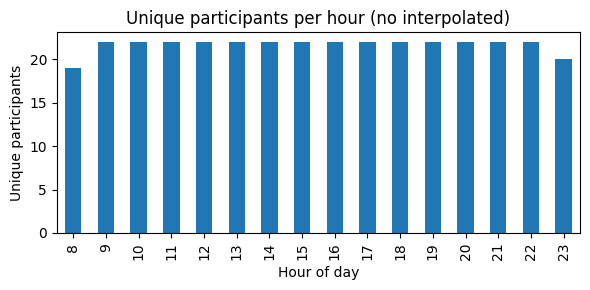

In [246]:
# drop rows created during interpolation
df_no_interp = positions_links_df[positions_links_df.get("interpolated") != True]

# plot unique participants per hour
hourly_unique = df_no_interp.groupby("hour_of_day")["id_participant"].nunique()
hourly_unique.plot(kind="bar", figsize=(6,3))

plt.xlabel("Hour of day")
plt.ylabel("Unique participants")
plt.title("Unique participants per hour (no interpolated)")
plt.tight_layout()
plt.show()

### Urban features

In [ ]:
# || URBAN FEATURES ||

if USE_URBAN_FEATURES:
    urban_features_to_use = ["GSI", "WMHB", "GrCR", "GD"]
    USE_URBAN_ROBUST_PERCENTILES = True   # set False to use simple min/max
    LOW_PCT_U, HIGH_PCT_U = 1, 99         # tweak if needed

    # 1) Select raw features and detect invalids/missing
    raw = nodes_df[urban_features_to_use].copy()
    invalid_mask = (raw == -1) | raw.isna()      # treat sentinel -1 and NaN as missing

    # 2) Build per-feature min/max on valid values
    valid = raw.mask(invalid_mask)               # hide invalids for stats
    if USE_URBAN_ROBUST_PERCENTILES:
        vmin = valid.quantile(LOW_PCT_U / 100.0)
        vmax = valid.quantile(HIGH_PCT_U / 100.0)
    else:
        vmin = valid.min(skipna=True)
        vmax = valid.max(skipna=True)

    # avoid divide-by-zero
    vrng = (vmax - vmin).replace(0, 1e-6)

    # 3) Scale to [0,1], 0-impute, and make mask columns
    scaled = ((valid - vmin) / vrng).clip(0.0, 1.0)
    scaled = scaled.fillna(0.0)  # neutral impute

    miss = invalid_mask.astype(float)
    miss.columns = [f"{c}_is_missing" for c in miss.columns]

    # 4) Final urban block: values + masks
    urban_aug = pd.concat([scaled, miss], axis=1)
    urban_features_array = urban_aug.values

    # 5) Build node features (coords + urban_aug)
    coords = nodes_df[['node_x', 'node_y']].values
    coords_min = coords.min(axis=0)
    coords_max = coords.max(axis=0)
    normalized_coords = (coords - coords_min) / (coords_max - coords_min)

    node_feature_array = np.hstack([normalized_coords, urban_features_array])
else:
    # If not using urban features, keep coords only (this matches your original logic)
    coords = nodes_df[['node_x', 'node_y']].values
    coords_min = coords.min(axis=0)
    coords_max = coords.max(axis=0)
    normalized_coords = (coords - coords_min) / (coords_max - coords_min)
    node_feature_array = np.hstack([normalized_coords])

node_features = torch.tensor(node_feature_array, dtype=torch.float)

### Timebin definition

In [248]:
# || assigning TIMEBINS ||

interval = 60 * 60 * 2      # time bin interval = 2h
                            # only choosing bin intervals that divide 24 hours evenly [1h, 2h, 3h, 4h, 6h, 8h, 12h, 24h]
                            
# start_time = positions_links_df["merged_datetime"].min()
positions_links_df["timestamp"] = pd.to_datetime(positions_links_df["timestamp"], utc=True).dt.tz_convert("Asia/Seoul")
start_time_dt = positions_links_df["timestamp"].dt.floor("D").min()                     # aligning to midnight of the first day
start_time = int(start_time_dt.timestamp())                                             # timestamp in seconds           
end_time = positions_links_df["merged_datetime"].max()

positions_links_df['time_seconds'] = positions_links_df['merged_datetime'] - start_time         # time in seconds since the start
positions_links_df['time_bin'] = (positions_links_df["time_seconds"] // interval).astype(int)   # dividing them into time bins
participant_counts = positions_links_df.groupby("time_bin")["id_participant"].nunique()         # counting the number of participants in each time bin

print("Start time (datetime):", start_time_dt)
print("Start time (timestamp):", start_time)

Start time (datetime): 2023-10-06 00:00:00+09:00
Start time (timestamp): 1696518000


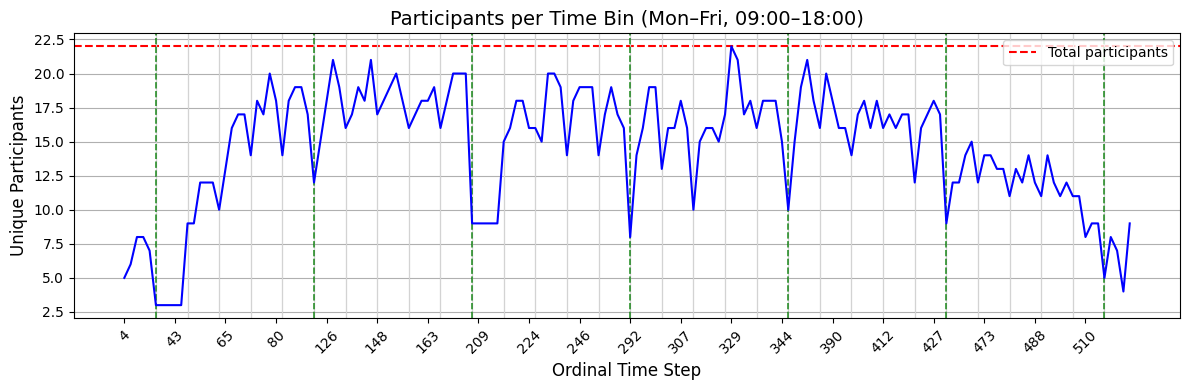

In [249]:
# ||  N. of participants per time bin (09:00 - 18:00, weekdays)  ||

plot_df = positions_links_df[(positions_links_df["hour_of_day"] >= 9) & (positions_links_df["hour_of_day"] < 18) & (positions_links_df["day_of_week"] <= 4)]
participant_counts = plot_df.groupby("time_bin")["id_participant"].nunique()

x_positions = np.arange(len(participant_counts))
x_labels = participant_counts.index

plt.figure(figsize=(12, 4))
plt.axhline(positions_links_df["id_participant"].nunique(), color='red', linestyle='--', label='Total participants')


all_bins = positions_links_df["time_bin"].unique()
all_bins = np.sort(all_bins)
included_bins = participant_counts.index
excluded_bins = np.setdiff1d(all_bins, included_bins)


bin_hour_map = positions_links_df.groupby("time_bin")["hour_of_day"].first().to_dict()
bin_day_map = positions_links_df.groupby("time_bin")["day_of_week"].first().to_dict()

# classifying excluded bins
weekday_night_bins = []
weekend_bins = []

for b in excluded_bins:
    day = bin_day_map.get(b, None)
    hour = bin_hour_map.get(b, None)
    if day is None or hour is None:
        continue
    if day <= 4:    # Monday to Friday
        if hour < 9 or hour >= 18:
            weekday_night_bins.append(b)
    else:           # Saturday or Sunday
        weekend_bins.append(b)

# Map bin values to ordinal x positions (same as x_labels)
bin_to_x = {b: i for i, b in enumerate(included_bins)}

# Plot vertical lines for removed bins
for b in weekday_night_bins:
    if b in bin_to_x:
        continue  # don't draw if this bin was actually kept
    idx = np.searchsorted(included_bins, b)
    if 0 <= idx < len(x_positions):
        plt.axvline(x=idx, color='lightgray', linestyle='-', linewidth=0.75, alpha =1)

for b in weekend_bins:
    idx = np.searchsorted(included_bins, b)
    if 0 <= idx < len(x_positions):
        plt.axvline(x=idx, color='green', linestyle='--', linewidth=1.2, alpha=0.05)

plt.plot(x_positions, participant_counts.values, color='blue')

plt.xticks(x_positions[::max(len(x_positions)//20,1)], x_labels[::max(len(x_labels)//20,1)], rotation=45)
plt.title("Participants per Time Bin (Mon–Fri, 09:00–18:00)", fontsize=14)
plt.xlabel("Ordinal Time Step", fontsize=12)
plt.ylabel("Unique Participants", fontsize=12)
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()

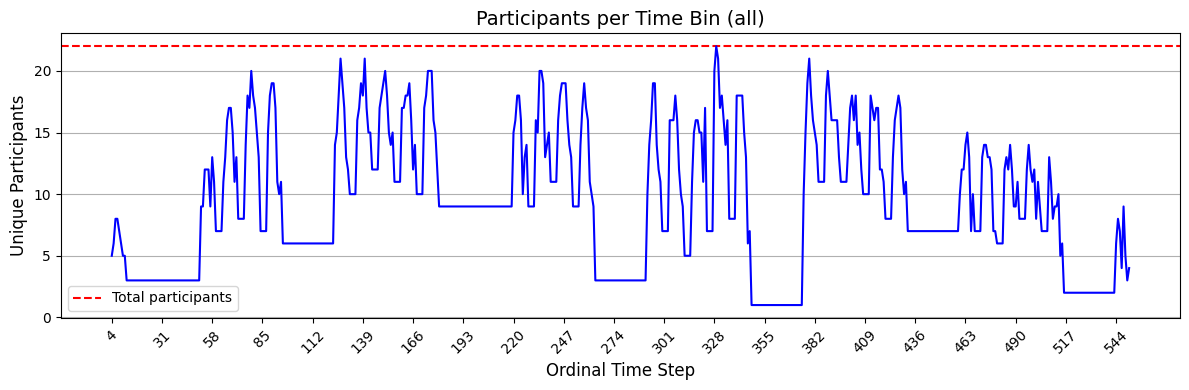

In [250]:
# plot to visualize how many participants are present per time bin (only between 09:00 and 18:00 and on weekdays)
plot_df = positions_links_df
participant_counts = plot_df.groupby("time_bin")["id_participant"].nunique()

x_positions = np.arange(len(participant_counts))
x_labels = participant_counts.index

plt.figure(figsize=(12, 4))
plt.axhline(positions_links_df["id_participant"].nunique(), color='red', linestyle='--', label='Total participants')

# Full set of bins and filtered set
all_bins = positions_links_df["time_bin"].unique()
all_bins = np.sort(all_bins)
included_bins = participant_counts.index
excluded_bins = np.setdiff1d(all_bins, included_bins)

# Map each bin to its weekday/hour (based on bin centers)
bin_hour_map = positions_links_df.groupby("time_bin")["hour_of_day"].first().to_dict()
bin_day_map = positions_links_df.groupby("time_bin")["day_of_week"].first().to_dict()

# Classify excluded bins
weekday_night_bins = []
weekend_bins = []

for b in excluded_bins:
    day = bin_day_map.get(b, None)
    hour = bin_hour_map.get(b, None)
    if day is None or hour is None:
        continue
    if day <= 4:  # Monday to Friday
        if hour < 9 or hour >= 18:
            weekday_night_bins.append(b)
    else:  # Saturday or Sunday
        weekend_bins.append(b)

# Map bin values to ordinal x positions (same as x_labels)
bin_to_x = {b: i for i, b in enumerate(included_bins)}

# Plot vertical lines for removed bins
for b in weekday_night_bins:
    if b in bin_to_x:
        continue  # don't draw if this bin was actually kept
    idx = np.searchsorted(included_bins, b)
    if 0 <= idx < len(x_positions):
        plt.axvline(x=idx, color='lightgray', linestyle='-', linewidth=0.75, alpha =1)

for b in weekend_bins:
    idx = np.searchsorted(included_bins, b)
    if 0 <= idx < len(x_positions):
        plt.axvline(x=idx, color='green', linestyle='--', linewidth=1.2, alpha=0.05)

plt.plot(x_positions, participant_counts.values, color='blue')

plt.xticks(x_positions[::max(len(x_positions)//20,1)], x_labels[::max(len(x_labels)//20,1)], rotation=45)
plt.title("Participants per Time Bin (all)", fontsize=14)
plt.xlabel("Ordinal Time Step", fontsize=12)
plt.ylabel("Unique Participants", fontsize=12)
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# __Creating the Network Graph__

In [251]:
# normalizing edge features
positions_links_df["hour_norm"] = positions_links_df["hour_of_day"] / 23.0     # hours: 0–23
positions_links_df["day_norm"] = positions_links_df["day_of_week"] / 6.0       # days: 0–6

speed_min = positions_links_df["speed"].min()
speed_max = positions_links_df["speed"].max()
positions_links_df["speed_norm"] = (positions_links_df["speed"] - speed_min) / (speed_max - speed_min)

In [ ]:
# making the node features
coords = nodes_df[['node_x', 'node_y']].values
coords_min = coords.min(axis=0)
coords_max = coords.max(axis=0)
normalized_coords = (coords - coords_min) / (coords_max - coords_min)  # normalizing coordinates to [0, 1]


if USE_URBAN_FEATURES:
    node_feature_array = np.hstack([normalized_coords, urban_features_array])
else:
    node_feature_array = np.hstack([normalized_coords])


node_features = torch.tensor(node_feature_array, dtype=torch.float)

In [253]:
def classify_transport_mode(speed):
    speed = speed * (speed_max - speed_min) + speed_min  # denormalizing the speed
    if speed <= 7.5:    # meters per second
        return 0        # Personal mobility (walking, biking, etc.)
    else:
        return 1        # Motorized mobility (car, metro, etc.)

In [ ]:
features = []
edge_indices = []
edge_weights = []
targets = []
edge_features = []

num_nodes = nodes_df["node_id"].nunique()
min_time_between_counts = 30 * 60  # 30 minutes in seconds

min_bin = 0
max_bin = int(positions_links_df['time_bin'].max())
all_time_bins = range(min_bin, max_bin + 1)

bin_context = {}

for t in all_time_bins:
    df_now = positions_links_df[positions_links_df['time_bin'] == t].copy()
    df_next = positions_links_df[positions_links_df['time_bin'] == t + 1].copy()

    # ─── BIN CONTEXT ─────────────────────────────────────────────
    bin_start = start_time_dt + pd.Timedelta(seconds=interval * t)
    bin_midpoint = bin_start + pd.Timedelta(seconds=interval // 2)

    avg_hour = bin_midpoint.hour + bin_midpoint.minute / 60
    day_of_week = bin_midpoint.dayofweek

    hour_norm = avg_hour / 23.0
    day_norm = day_of_week / 6.0

    bin_context[t] = (hour_norm, day_norm)

    # ─── NODE FEATURES ───────────────────────────────────────────
    visit_df = df_now.groupby("node_id").size()
    visit_counts = visit_df.reindex(range(num_nodes), fill_value=0).values
    visit_tensor = torch.tensor(visit_counts, dtype=torch.float).unsqueeze(1)

    full_node_features = torch.cat([visit_tensor, node_features], dim=1)
    features.append(full_node_features)

    # ─── EDGE FEATURES ───────────────────────────────────────────
    if not df_now.empty:
        grouped = df_now.groupby(["prev_node_id", "node_id"]).agg({
            "hour_norm": "mean",
            "day_norm": "mean",
            "speed_norm": "mean",
            "id_participant": "count"  # this is flow
        }).rename(columns={"id_participant": "flow"}).reset_index()

        grouped["transport"] = grouped["speed_norm"].apply(classify_transport_mode)

        source = torch.tensor(grouped["prev_node_id"].values, dtype=torch.long)
        destination = torch.tensor(grouped["node_id"].values, dtype=torch.long)
        edge_index = torch.stack([source, destination], dim=0)

        edge_feat = torch.tensor(grouped[["hour_norm", "day_norm", "flow", "transport"]].values, dtype=torch.float)
        edge_weight = torch.ones(edge_index.size(1))
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_feat = torch.empty((0, 4), dtype=torch.float)
        edge_weight = torch.empty((0,))

    edge_indices.append(edge_index)
    edge_weights.append(edge_weight)
    edge_features.append(edge_feat)

    # ─── NODE TARGETS (filtered with same logic) ────────────────
    if df_next.empty:
        node_target = torch.zeros(num_nodes)
    else:
        visit_df = df_next.groupby("node_id").size()
        visit_counts = visit_df.reindex(range(num_nodes), fill_value=0).values
        node_target = torch.tensor(visit_counts, dtype=torch.float)

    # ─── EDGE TARGETS (raw from df_next, not filtered) ──────────
    if df_next.empty:
        flow_target = torch.empty((0,))
        next_edge_index = torch.empty((2, 0), dtype=torch.long)
        transport_target = torch.empty((0,), dtype=torch.long)
        edge_feat_target = torch.empty((0, 3), dtype=torch.float)
    else:
        grouped_next = df_next.groupby(["prev_node_id", "node_id"]).agg({
            "speed_norm": "mean",
            "hour_norm": "mean",
            "day_norm": "mean",
            "id_participant": "count"  # This is flow
        }).rename(columns={"id_participant": "flow"}).reset_index()

        grouped_next["transport"] = grouped_next["speed_norm"].apply(classify_transport_mode)

        next_source_node = torch.tensor(grouped_next["prev_node_id"].values, dtype=torch.long)
        next_destination_node = torch.tensor(grouped_next["node_id"].values, dtype=torch.long)
        next_edge_index = torch.stack([next_source_node, next_destination_node], dim=0)

        flow_target = torch.tensor(grouped_next["flow"].values, dtype=torch.float)       ##This is what was changed CHECK!
        transport_target = torch.tensor(grouped_next["transport"].values, dtype=torch.long)
        edge_feat_target = torch.tensor(
            grouped_next[["hour_norm", "day_norm"]].values,
            dtype=torch.float
        )

    targets.append((node_target, next_edge_index, flow_target, transport_target, edge_feat_target))

In [255]:
graph_snapshots = []

for t in all_time_bins:
    snapshot = {
        "x": features[t],                         # Node features
        "edge_index": edge_indices[t],            # Edge indices
        "edge_weight": edge_weights[t],           # Edge weights (unused for now)
        "edge_feat": edge_features[t],            # Edge features (speed_norm, hour_norm, day_norm)
        "target_node": targets[t][0],             # Node-level target
        "target_edge_index": targets[t][1],       # Edges to predict speed for
        "target_edge_speed": targets[t][2],       # Edge-level speed prediction
    }
    graph_snapshots.append(snapshot)

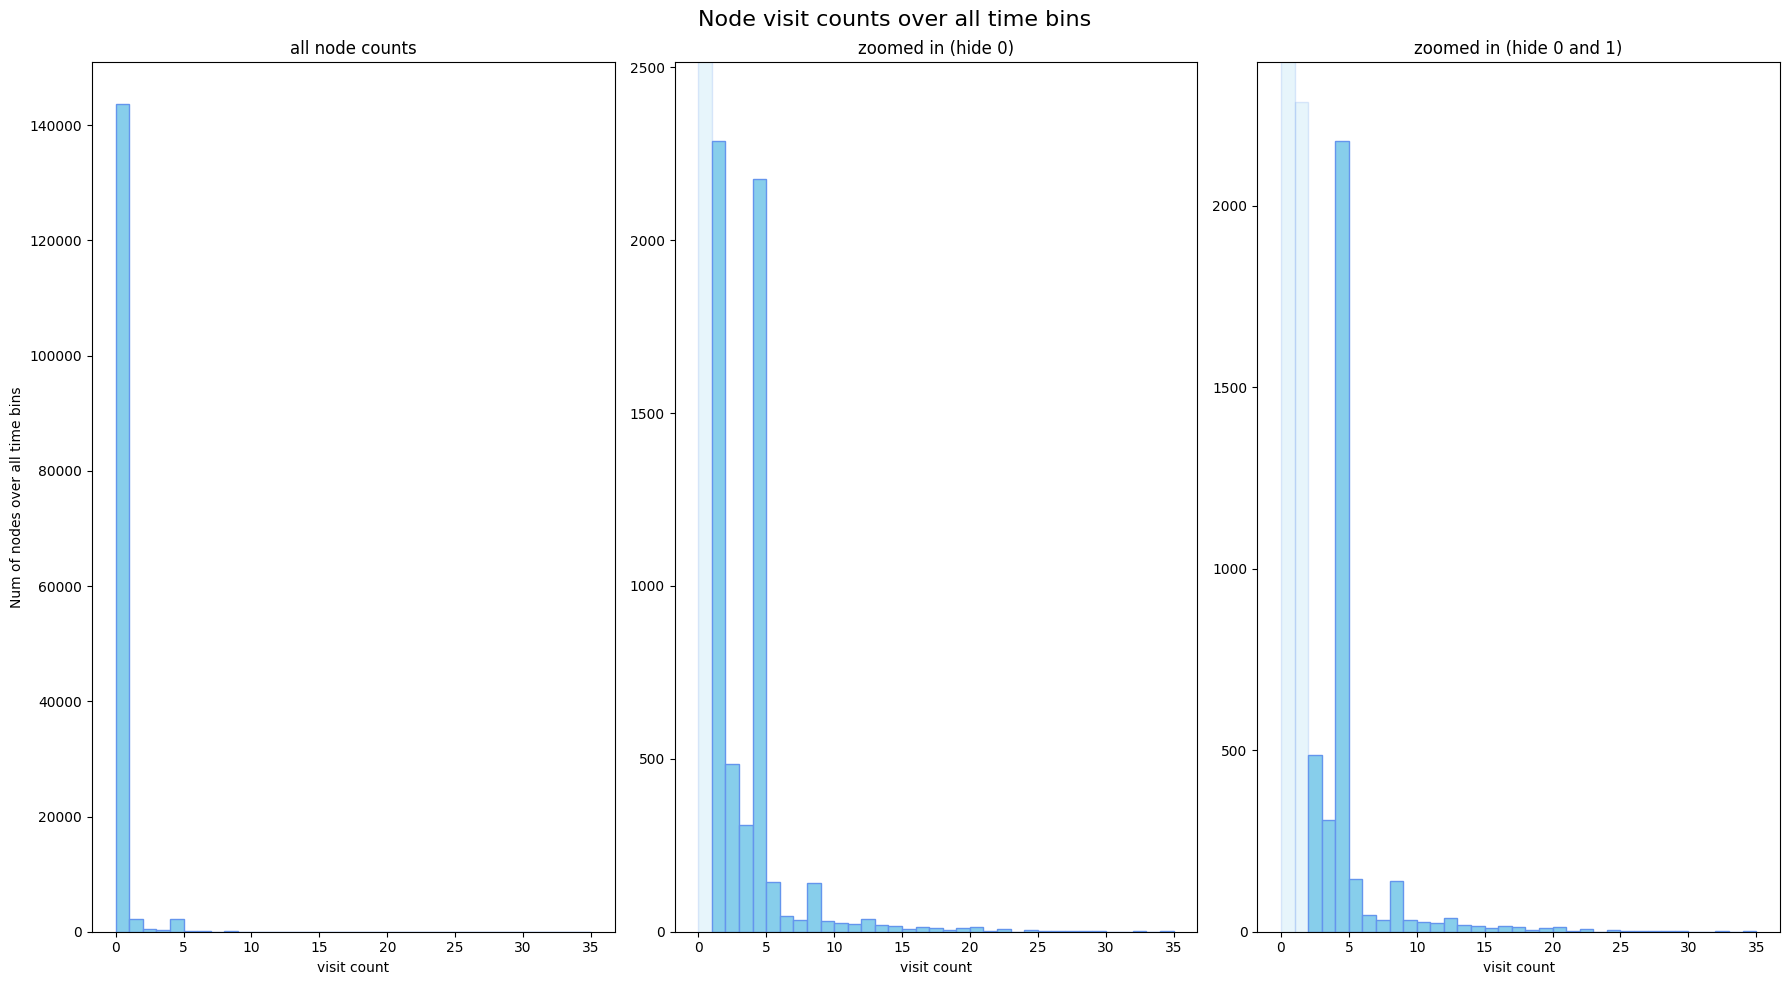

In [ ]:

all_node_counts = []

for t in range(len(targets)):
    counts = targets[t][0].numpy()  # Node visit counts
    all_node_counts.extend(counts.tolist())

counts_hist, bins_hist = np.histogram(all_node_counts, bins=range(int(max(all_node_counts)) + 2))

fig, axes = plt.subplots(1, 3, figsize=(18, 10), sharey=False)
fig.suptitle("Node visit counts over all time bins", fontsize=16)

# --- Full Histogram ---
axes[0].hist(all_node_counts, bins=range(int(max(all_node_counts)) + 2), color='skyblue', edgecolor='cornflowerblue')
axes[0].set_title("all node counts")
axes[0].set_xlabel("visit count")
axes[0].set_ylabel("Num of nodes over all time bins")

# --- Zoomed in (exclude 0 bar visually) ---
bars = axes[1].hist(all_node_counts, bins=range(int(max(all_node_counts)) + 2), color='skyblue', edgecolor='cornflowerblue')
bars[2][0].set_alpha(0.2)  # Make 0-count bar transparent
axes[1].set_ylim(0, max(bars[0][1:]) * 1.1)
axes[1].set_title("zoomed in (hide 0)")
axes[1].set_xlabel("visit count")

# --- Zoomed in (exclude 0 and 1 visually) ---
bars = axes[2].hist(all_node_counts, bins=range(int(max(all_node_counts)) + 2), color='skyblue', edgecolor='cornflowerblue')
bars[2][0].set_alpha(0.2)  # 0 bar
bars[2][1].set_alpha(0.2)  # 1 bar
axes[2].set_ylim(0, max(bars[0][2:]) * 1.1)
axes[2].set_title("zoomed in (hide 0 and 1)")
axes[2].set_xlabel("visit count")

plt.tight_layout()
plt.show()

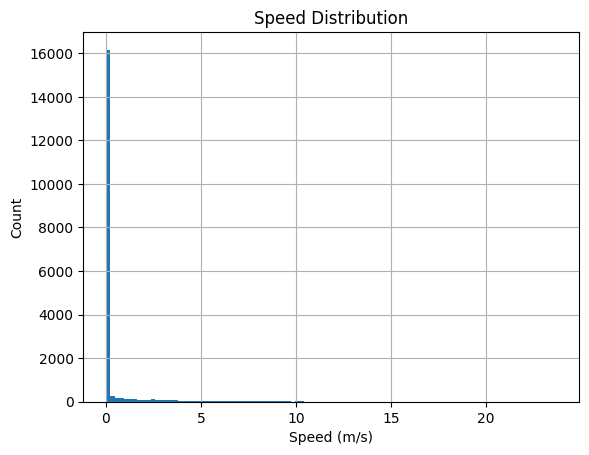

In [258]:
plt.hist(positions_links_df["speed"], bins=100)
plt.xlabel("Speed (m/s)")
plt.ylabel("Count")
plt.title("Speed Distribution")
plt.grid()
plt.show()

# __Setting up Climate Features__

In [ ]:

node_xy = nodes_df[["node_x", "node_y"]].to_numpy(dtype=float) 

ALLOWED_NODE_TYPES = {"intersection", "subminicipality_detailed"}
if USING_INTERSECTION_NODE_TYPE:
    invalid_climate_mask = (~nodes_df["node_type"].isin(ALLOWED_NODE_TYPES)).to_numpy()
else:
    invalid_climate_mask = None

node_xy = nodes_df[["node_x", "node_y"]].to_numpy(dtype=float)

cfg = ClimateConfig(
    weather_csv=os.path.join(BASE_DIR, "Data/S-DoT_sensors/S-DoT_NATURE_20230724-20230826_en.csv"),
    stations_csv=os.path.join(BASE_DIR, "Data/S-DoT_sensors/s-dot-locations.csv"),
    var_cols=[
        "temperature_mean_C",
        "humidity_mean_pc",
        "PM10_mean_microgm3",
    ],
    start_time_dt=start_time_dt,
    bin_seconds=interval,
    max_gap_minutes=90,
    node_xy_crs="EPSG:5174",
    station_ll_crs="EPSG:4326",
    cache_dir=os.path.join(BASE_DIR, "Data/S-DoT_sensors/climate_cache"),
    station_id_col="SerialNum",
    station_lon_col="Xlon",
    station_lat_col="Ylat",
    weather_id_col="serial",
    weather_time_col="datetime",
)
climate_by_bin, climate_feat_names, cache_used = compute_node_climate_by_bin(cfg, node_xy, use_cache=True)
print(f"Climate cache used/saved at: {cache_used}")

Climate cache used/saved at: D:/Desktop/MSc Thesis - Copy/climate_cache\node_climate_bins_fc0e8c5b533d.parquet


# __Creating and Training the Model__

In [ ]:
from torch_geometric.nn import NNConv
from torch.nn import GRUCell, Linear, ReLU, Sequential

class EdgeAwareTemporalEncoder(nn.Module):
    def __init__(self, in_channels, edge_feat_dim, hidden_dim):
        super().__init__()

        # edge-conditioned MLP to produce weights for each edge
        self.edge_nn = Sequential(
            Linear(edge_feat_dim, 32),
            ReLU(),
            Linear(32, in_channels * hidden_dim)
        )

        # NNConv does edge-conditioned message passing
        self.conv = NNConv(
            in_channels=in_channels,
            out_channels=hidden_dim,
            nn=self.edge_nn,
            aggr='mean'
        )

        # GRU maintains temporal state across time steps
        self.gru = GRUCell(hidden_dim, hidden_dim)

    def forward(self, x_seq, edge_index_seq, edge_attr_seq):
        h = None

        for x, edge_index, edge_attr in zip(x_seq, edge_index_seq, edge_attr_seq):
            out = self.conv(x, edge_index, edge_attr)
            if h is None:
                h = out
            else:
                h = self.gru(out, h)
        return h

In [ ]:
class MovementLinkPredictor(nn.Module):
    def __init__(self, in_channels, encoder_edge_feat_dim, time_feat_dim, hidden_dim):
        super().__init__()

        self.encoder = EdgeAwareTemporalEncoder(
            in_channels=in_channels,
            edge_feat_dim=encoder_edge_feat_dim,
            hidden_dim=hidden_dim
        )

        # node target prediction
        self.node_decoder = nn.Sequential(
            Linear(hidden_dim + time_feat_dim, 64), 
            ReLU(),
            Linear(64, 1),
        )

        self.edge_flow_decoder = nn.Sequential(
            nn.Linear(2 * hidden_dim + time_feat_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.transport_decoder = nn.Sequential(
            nn.Linear(2 * hidden_dim + time_feat_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward_encoder(self, x_seq, edge_index_seq, edge_attr_seq):
        return self.encoder(x_seq, edge_index_seq, edge_attr_seq)

    def predict_node_counts(self, z, time_feat):
        combined = torch.cat([z, time_feat], dim=1)
        return self.node_decoder(combined).squeeze(1)

    def predict_edge_flow(self, z, edge_index, time_feat):
        src = z[edge_index[0]]
        dst = z[edge_index[1]]
        combined = torch.cat([src, dst, time_feat], dim=1)
        return self.edge_flow_decoder(combined).squeeze(1)

    def predict_edge_mode(self, z, edge_index, time_feat):
        src = z[edge_index[0]]
        dst = z[edge_index[1]]
        combined = torch.cat([src, dst, time_feat], dim=1)
        return self.transport_decoder(combined)

In [ ]:
def generate_stratified_split_with_val(all_bins, train_ratio=0.7, val_ratio=0.2, stride=3):
    """
    Splits all_bins into train/val/test using stratified sampling and stride.
    Ensures bins are evenly spaced and mutually exclusive.
    """
    # Step 1: Stratified sampling using stride
    sampled_bins = all_bins[::stride]

    # Step 2: Split into train/val/test
    total = len(sampled_bins)
    train_cutoff = int(total * train_ratio)
    val_cutoff = int(total * (train_ratio + val_ratio))

    train_bins = sampled_bins[:train_cutoff]
    val_bins = sampled_bins[train_cutoff:val_cutoff]
    used_bins = set(sampled_bins[:val_cutoff])
    test_bins = [b for b in all_bins if b not in used_bins]

    return train_bins, val_bins, test_bins

def assign_time_bins_by_day_cadence(df, window_size):
    """
    Assigns time bins to train/val/test groups in a repeating pattern:
    [4 days train, 2 days val, 3 days train, 1 day test], ensuring val/test bins
    take precedence over overlapping train bins.
    This gives a 70% train, 20% val, 10% test split.
    """

    min_day = df["day"].min()
    df["day_index"] = (df["day"] - min_day).dt.days

    unique_days = sorted(df["day_index"].unique())
    total_days = len(unique_days)

    pattern = (["train"] * 4) + (["val"] * 2) + (["train"] * 3) + (["test"] * 1)
    pattern_length = len(pattern)

    full_blocks = total_days // pattern_length
    day_to_group = {}

    for block in range(full_blocks):
        start = block * pattern_length
        block_days = unique_days[start:start+pattern_length]
        for i, day in enumerate(block_days):
            day_to_group[day] = pattern[i]

    remainder_days = unique_days[full_blocks * pattern_length:]
    remaining_count = len(remainder_days)

    if remaining_count > 0:
        n_train = round(10/10 * remaining_count)
        n_val = round(0/10 * remaining_count)
        n_test = remaining_count - n_train - n_val
        assigned = 0
        for day in remainder_days[:n_train]:
            day_to_group[day] = "train"
            assigned += 1
        for day in remainder_days[assigned:assigned + n_val]:
            day_to_group[day] = "val"
            assigned += 1
        for day in remainder_days[assigned:]:
            day_to_group[day] = "test"


    df["group"] = df["day_index"].map(day_to_group)
    bin_groups = df.groupby("time_bin")["group"].agg(lambda x: x.value_counts().idxmax())

    print("Train days:", sum(1 for g in day_to_group.values() if g == "train"))
    print("Val days:", sum(1 for g in day_to_group.values() if g == "val"))
    print("Test days:", sum(1 for g in day_to_group.values() if g == "test"))

    bin_groups_dict = bin_groups.to_dict()

    for t in bin_groups.index:
        group = bin_groups[t]
        input_bins = range(t - window_size, t)

        for b in input_bins:
            if b in bin_groups_dict:
                input_group = bin_groups_dict[b]
                if group == "val" and input_group == "train":
                    bin_groups_dict[b] = None
                elif group == "test" and input_group in ("train", "val"):
                    bin_groups_dict[b] = None
                elif group == "train" and input_group in ("val", "test"):
                    bin_groups_dict[t] = None


    # Filter by group
    train_bins = [t for t, g in bin_groups_dict.items() if g == "train"]
    val_bins   = [t for t, g in bin_groups_dict.items() if g == "val"]
    test_bins  = [t for t, g in bin_groups_dict.items() if g == "test"]

    print(f"Total bins: {len(bin_groups)}")
    print(f"Train bins: {len(train_bins)}, Val bins: {len(val_bins)}, Test bins: {len(test_bins)}")

    return train_bins, val_bins, test_bins

In [ ]:
def plot_time_bin_split(train_bins, val_bins, test_bins, title="Time Bin Grouping Over Time"):
    """
    Plots time bins assigned to train, val, and test sets across time.
    """
    group_labels = []
    for b in train_bins:
        group_labels.append((b, "train"))
    for b in val_bins:
        group_labels.append((b, "val"))
    for b in test_bins:
        group_labels.append((b, "test"))

    group_labels.sort()
    bin_numbers = [x[0] for x in group_labels]
    group_names = [x[1] for x in group_labels]

    color_map = {"train": "green", "val": "dodgerblue", "test": "orange"}
    colors = [color_map[g] for g in group_names]

    plt.figure(figsize=(12, 2.5))
    plt.scatter(bin_numbers, [1]*len(bin_numbers), c=colors, marker='|', s=200)
    plt.yticks([])
    plt.xlabel("Time Bin Index")
    plt.title(title)
    legend_elements = [
        plt.Line2D([0], [0], marker='|', color='w', label='Train', markerfacecolor='green', markersize=10),
        plt.Line2D([0], [0], marker='|', color='w', label='Validation', markerfacecolor='dodgerblue', markersize=10),
        plt.Line2D([0], [0], marker='|', color='w', label='Test', markerfacecolor='orange', markersize=10)
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.grid(axis='x', color='lightgray', linestyle='--')
    plt.tight_layout()
    plt.show()

In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

window_size = 5
embedding_dim = 64
learning_rate = 0.01
num_epochs = 60

num_nodes = features[0].shape[0]
for ef in edge_features:
    if ef.size(0) > 0:
        edge_feat_dim = ef.shape[1]
        break

encoder_edge_feat_dim = 4   # count, hour, day, speed 
time_feat_dim = 2   # hour, day
all_bins = list(range(window_size, len(features)))

Train days: 34
Val days: 8
Test days: 4
Total bins: 548
Train bins: 324, Val bins: 96, Test bins: 48


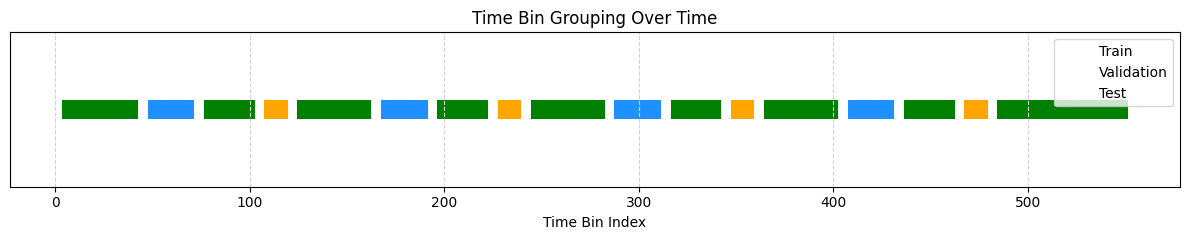

Train bins size: 324
Validation bins size: 96
Test bins size: 48
Train bins percentage: 0.6923076923076923
Validation bins percentage: 0.20512820512820512
Test bins percentage: 0.10256410256410256


In [ ]:
train_bins, val_bins, test_bins = assign_time_bins_by_day_cadence(
    positions_links_df,
    window_size=window_size
)

plot_time_bin_split(train_bins, val_bins, test_bins)

print("Train bins size:", len(train_bins))
print("Validation bins size:", len(val_bins))
print("Test bins size:", len(test_bins))
print("Train bins percentage:", len(train_bins) / (len(train_bins) + len(val_bins) + len(test_bins)))
print("Validation bins percentage:", len(val_bins) / (len(train_bins) + len(val_bins) + len(test_bins)))
print("Test bins percentage:", len(test_bins) / (len(train_bins) + len(val_bins) + len(test_bins)))

In [ ]:
# Robust scaling with percentiles vs simple min/max
USE_ROBUST_PERCENTILES = True
LOW_PCT, HIGH_PCT = 1, 99

num_climate = len(climate_feat_names)
num_nodes = nodes_df["node_id"].nunique()

if USE_CLIMATE_FEATURES and num_climate > 0:
    train_clims = [climate_by_bin[b] for b in train_bins if b in climate_by_bin]
    if len(train_clims) == 0:
        print("Warning: no climate bins in training split; falling back to all bins for scaling.")
        train_clims = [climate_by_bin[b] for b in all_time_bins if b in climate_by_bin]

    stack = np.stack(train_clims, axis=0).astype(float)         # [T_train, N, V]
    stack[stack == -1.0] = np.nan                                # sentinel -> missing
    if invalid_climate_mask is not None:
        stack[:, invalid_climate_mask, :] = np.nan

    if USE_ROBUST_PERCENTILES:
        vmin = np.nanpercentile(stack, LOW_PCT, axis=(0, 1))    # [V]
        vmax = np.nanpercentile(stack, HIGH_PCT, axis=(0, 1))   # [V]
        method_name = f"robust percentiles {LOW_PCT}/{HIGH_PCT}"
    else:
        vmin = np.nanmin(stack, axis=(0, 1))
        vmax = np.nanmax(stack, axis=(0, 1))
        method_name = "simple min/max"
    vrng = np.maximum(vmax - vmin, 1e-6)

    print(f"[Climate scaling] Using {method_name}.")
    print("  Example (first 3 vars):")
    print("    vmin:", np.round(vmin[:3], 3))
    print("    vmax:", np.round(vmax[:3], 3))

    default_clim = np.full((num_nodes, num_climate), np.nan, dtype=float)

    for t in all_time_bins:
        clim_np = climate_by_bin.get(t, default_clim).astype(float).copy()
        clim_np[clim_np == -1.0] = np.nan
        if invalid_climate_mask is not None:
            clim_np[invalid_climate_mask, :] = np.nan

        scaled = (clim_np - vmin) / vrng
        miss = np.isnan(scaled).astype(float)                 
        scaled = np.nan_to_num(scaled, nan=0.0)
        scaled = np.clip(scaled, 0.0, 1.0)

        clim_aug = np.concatenate([scaled, miss], axis=1).astype(np.float32)
        features[t] = torch.cat([features[t], torch.from_numpy(clim_aug)], dim=1)

print("\n[Sanity] Input feature dim per node:", features[0].shape[1])
print("[Sanity] Edge feature dim (encoder):", encoder_edge_feat_dim)
print("[Sanity] Time feature dim:", time_feat_dim)

[Climate scaling] Using robust percentiles 1/99.
  Example (first 3 vars):
    vmin: [-0.934 29.948  0.   ]
    vmax: [24.904 99.36  40.978]

[Sanity] Input feature dim per node: 17
[Sanity] Edge feature dim (encoder): 4
[Sanity] Time feature dim: 2


In [ ]:
model = MovementLinkPredictor(
    in_channels=features[0].shape[1],                       # node features + visit counts
    encoder_edge_feat_dim=encoder_edge_feat_dim,            # edge features (hour, day, speed)
    time_feat_dim=time_feat_dim,                            # edge features (hour, day)
    hidden_dim=embedding_dim                                # hidden dimension for GRU and NNConv
)
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, threshold=0.0005, verbose=True)

c:\Users\Michele\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

In [271]:
from collections import Counter

all_targets = []
for t in train_bins:
    is_active = (targets[t - 1][0] >= 1).float()  # binary labels
    all_targets.extend(is_active.tolist())

counts = Counter(all_targets)
num_neg = counts[0.0]
num_pos = counts[1.0]

pos_weight = num_neg / num_pos
print(f"Suggested pos_weight: {pos_weight:.2f}")

Suggested pos_weight: 25.24


In [ ]:
manual_max_losses = {
    "node_count": 1,
    "node_presence": 1,
    "edge_flow": 1,
    "transport_mode": 1
}

In [ ]:
def count_to_probability(counts, eps=1e-6):
    """
    Converts predicted node counts 0 to 1 values.
    Caps at 1.0.
    """
    probability_active = torch.clamp(counts, 0.0, 1.0)   # linear mapping to [0, 1]
    probability_active = torch.clamp(probability_active, eps, 1 - eps)  # numerical safety
    return probability_active

In [ ]:
import torch.nn.functional as F

def compute_loss(model, features, edge_indices, edge_features, targets, bins, bin_context, pos_weight=20.0):
    model.eval()
    loss_sum, mse_total, presence_total, edge_total, mode_total = 0, 0, 0, 0, 0
    count = 0

    with torch.no_grad():
        for t in bins:
            x_seq = features[t - window_size:t]
            ei_seq = edge_indices[t - window_size:t]
            ef_seq = edge_features[t - window_size:t]

            if all(ei.size(1) == 0 for ei in ei_seq):
                continue

            z = model.forward_encoder(x_seq, ei_seq, ef_seq)
            future_hour, future_day = bin_context[t]
            time_feat = torch.tensor([[future_hour, future_day]], dtype=torch.float)
            num_nodes = features[0].shape[0]
            node_time_feat = time_feat.repeat(num_nodes, 1)

            node_target = targets[t - 1][0]
            node_pred = model.predict_node_counts(z, node_time_feat)
            is_active = (node_target >= 1).float()

            p_active = count_to_probability(node_pred)
            presence_weights = torch.where(is_active == 1, torch.tensor(1.0), torch.tensor(1.0))
            presence_loss = F.binary_cross_entropy(p_active, is_active, weight=presence_weights)

            node_weights = torch.where(node_target>0, torch.tensor(1.0), torch.tensor(1.0))
            mse_loss = F.mse_loss(node_pred, node_target, reduction='none')
            mse_loss = (mse_loss * node_weights).sum() / node_weights.sum()

            node_loss = (mse_loss * node_weights).mean() + 1.0 * presence_loss

            edge_loss, mode_loss = torch.tensor(0.0), torch.tensor(0.0)
            active_nodes = (node_pred >= 0.5).nonzero(as_tuple=False).flatten()
            if active_nodes.numel() > 0:
                from itertools import product
                df_prev = positions_links_df[positions_links_df["time_bin"] == t - 1]
                last_locations = df_prev.sort_values("merged_datetime").groupby("id_participant").tail(1)
                source_nodes = torch.tensor(last_locations["node_id"].unique(), dtype=torch.long)
                candidate_edges = torch.tensor(list(set(product(source_nodes.tolist(), active_nodes.tolist())) | set(product(active_nodes.tolist(), active_nodes.tolist()))), dtype=torch.long).T

                edge_time_feat = time_feat.repeat(candidate_edges.shape[1], 1)
                true_edge_index, true_flow, true_mode = targets[t - 1][1], targets[t - 1][2], targets[t - 1][3]
                true_edge_dict = {tuple(e): i for i, e in enumerate(true_edge_index.T.tolist())}


                # 
                exists_mask = torch.tensor([(int(s), int(d)) in true_edge_dict for s, d in candidate_edges.T], dtype=torch.bool)
                flow_targets = torch.tensor([true_flow[true_edge_dict[(int(s), int(d))]] if (int(s), int(d)) in true_edge_dict else 0.0
                        for s, d in candidate_edges.T], dtype=torch.float)

                edge_time_feat = time_feat.repeat(candidate_edges.shape[1], 1)
                edge_flow_pred = model.predict_edge_flow(z, candidate_edges, edge_time_feat)
                
                flow_weights = torch.where(flow_targets > 0, torch.tensor(10), torch.tensor(1.0))
                edge_loss = F.mse_loss(edge_flow_pred, flow_targets, reduction='none')
                edge_loss = (edge_loss * flow_weights).mean()

                if exists_mask.sum() > 0:
                    valid_edges = candidate_edges[:, exists_mask]
                    mode_targets = torch.tensor([true_mode[true_edge_dict[(int(s), int(d))]] for s, d in valid_edges.T], dtype=torch.long)
                    mode_logits = model.predict_edge_mode(z, valid_edges, time_feat.repeat(valid_edges.shape[1], 1))
                    mode_loss = F.cross_entropy(mode_logits, mode_targets)
                else:
                        mode_loss = torch.tensor(0.0)     

            norm_mse = mse_loss / manual_max_losses["node_count"]
            norm_bce = presence_loss / manual_max_losses["node_presence"]
            
            norm_edge = edge_loss / manual_max_losses["edge_flow"]
            norm_mode = mode_loss / manual_max_losses["transport_mode"]

            presence_loss = torch.tensor(0.0)
            norm_bce = 0 

            total_loss = norm_mse + norm_bce + norm_edge + norm_mode

            loss_sum += total_loss.item()
            mse_total += mse_loss.item()
            presence_total += presence_loss.item()
            edge_total += edge_loss.item()
            mode_total += mode_loss.item()
            count += 1

    if count == 0:
        return float('nan'), float('nan'), float('nan'), float('nan'), float('nan')
    return loss_sum/count, mse_total/count, presence_total/count, edge_total/count, mode_total/count

In [275]:
total_active = 0
total_nodes = 0
for t in train_bins:
    node_target = targets[t - 1][0]
    is_active = (node_target >= 1).float()
    total_active += is_active.sum().item()
    total_nodes += len(is_active)

pos_rate = total_active / total_nodes
print(f"True active rate: {pos_rate:.4f} ({total_active}/{total_nodes})")
print(f"Suggested pos_weight: {(1 - pos_rate) / pos_rate:.2f}")

True active rate: 0.0381 (3346.0/87804)
Suggested pos_weight: 25.24


In [ ]:
import time
from itertools import product

start_time_train = time.time()

# --- Training Loop ---
losses_total = []
losses_mse = []
losses_presence = []
losses_edge = []
losses_mode = []

normalized_total = []
normalized_mse = []
normalized_bce = []
normalized_edge = []
normalized_mode = []

val_losses_total = []
val_losses_mse = []
val_losses_presence = []
val_losses_edge = []
val_losses_mode = []

val_normalized_total = []
val_normalized_mse = []
val_normalized_bce = []
val_normalized_edge = []
val_normalized_mode = []

max_node_mse = 0.0
max_presence_loss = 0.0
max_edge_loss = 0.0
max_mode_loss = 0.0

for epoch in range(num_epochs):
    model.train()
    loss_sum = 0
    step_count = 0
    mse_total = 0.0
    presence_total = 0.0
    edge_total = 0.0
    mode_total = 0.0
    active_nodes_total = 0
    candidate_edges_total = 0
    total_nonzero_flows = 0
    total_edge_preds = 0
    total_mode_counts = torch.zeros(2, dtype=torch.long)

    epoch_start = time.time()

    for t in train_bins:
        

        x_seq = features[t - window_size:t]
        ei_seq = edge_indices[t - window_size:t]
        ef_seq = edge_features[t - window_size:t]

        if all(ei.size(1) == 0 for ei in ei_seq):
            step_count += 1
            #print('a')
            continue
        
        

        z = model.forward_encoder(x_seq, ei_seq, ef_seq)

        future_hour, future_day = bin_context[t]
        time_feat = torch.tensor([[future_hour, future_day]], dtype=torch.float)

        # 1. NODE flow and presence prediction
        node_target = targets[t - 1][0]                     
        node_time_feat = time_feat.repeat(num_nodes, 1)     
        node_pred = model.predict_node_counts(z, node_time_feat)
        active_nodes = (node_pred >= 0.5).nonzero(as_tuple=False).flatten()
            
        
        is_active = (node_target >= 1).float()
        p_active = count_to_probability(node_pred)
        presence_weights = torch.where(is_active == 1, torch.tensor(1.0), torch.tensor(1.0))
        

        
        presence_loss = F.binary_cross_entropy(p_active, is_active, weight=presence_weights)


        presence_loss = torch.tensor(0.0)
        norm_bce = 0

        node_weights = torch.where(node_target>0, torch.tensor(1.0), torch.tensor(1.0))
        mse_loss = F.mse_loss(node_pred, node_target, reduction='none')
        mse_loss = (mse_loss * node_weights).sum() / node_weights.sum()


        
        node_loss = mse_loss + 1.0 * presence_loss



        # 2. Last time step NODEs
        df_prev = positions_links_df[positions_links_df["time_bin"] == t - 1]
        last_locations = (
            df_prev.sort_values("merged_datetime")  # make sure it's sorted by time
                .groupby("id_participant")          # group by person
                .tail(1)                            # get last row per person
        )


        # Extract unique last node_ids
        source_nodes = torch.tensor(last_locations["node_id"].unique(), dtype=torch.long)


        # 3. Candidate edges
        source_to_active = list(product(source_nodes.tolist(), active_nodes.tolist()))
        active_to_active = list(product(active_nodes.tolist(), active_nodes.tolist()))
        all_candidate_pairs = list(set(source_to_active + active_to_active))

        candidate_edges = torch.tensor(all_candidate_pairs, dtype=torch.long).T        




        # True edge targets (at time t)
        true_edge_index = targets[t - 1][1]   # from time t
        true_flow = targets[t - 1][2]
        true_mode = targets[t - 1][3]

        true_edge_dict = {tuple(e): i for i, e in enumerate(true_edge_index.T.tolist())} # dictionary for fast lookup
        


        # actual existing edges in the candidate set
        exists_mask = torch.tensor([(int(s), int(d)) in true_edge_dict for s, d in candidate_edges.T], dtype=torch.bool)



        # Flow prediction targets on all candidates (including 0s)
        flow_targets = torch.tensor([true_flow[true_edge_dict[(int(s), int(d))]] if (int(s), int(d)) in true_edge_dict else 0.0 
                                     for s, d in candidate_edges.T], dtype=torch.float)
        


        # Edge Decoder calls
        edge_loss = torch.tensor(0.0)
        mode_loss = torch.tensor(0.0)



        if active_nodes.numel() > 0:
            edge_time_feat = time_feat.repeat(candidate_edges.shape[1], 1)
            edge_flow_pred = model.predict_edge_flow(z, candidate_edges, edge_time_feat)
            # weighted loss to make positive edges more significant
            # pos_weight = 10.0
            flow_weights = torch.where(flow_targets > 0, torch.tensor(10), torch.tensor(1.0))
            edge_loss = F.mse_loss(edge_flow_pred, flow_targets, reduction='none')
            edge_loss = (edge_loss * flow_weights).mean()


            # Mode prediction targets only existing candidates
            if exists_mask.sum() > 0:
                valid_edges = candidate_edges[:, exists_mask]
                mode_targets = torch.tensor([true_mode[true_edge_dict[(int(s), int(d))]] for s, d in valid_edges.T], dtype=torch.long)
                mode_logits = model.predict_edge_mode(z, valid_edges, time_feat.repeat(valid_edges.shape[1], 1))
                mode_loss = F.cross_entropy(mode_logits, mode_targets)

                # Optional: update class counts only if mode_targets exists
                mode_class_counts = torch.bincount(mode_targets, minlength=2)
                total_mode_counts += mode_class_counts

            else:
                mode_loss = torch.tensor(0.0)     




        # ---  counting nonzero flows and transport modes  ---
        nonzero_flows = (flow_targets > 0).sum().item()
        # mode_class_counts = torch.bincount(mode_targets, minlength=2)

        total_nonzero_flows += nonzero_flows
        # total_mode_counts += mode_class_counts
        total_edge_preds += flow_targets.numel()
        # ----------------------------------------------------        

        norm_mse = mse_loss / manual_max_losses["node_count"]
        norm_bce = presence_loss / manual_max_losses["node_presence"]
        norm_edge = edge_loss / manual_max_losses["edge_flow"]
        norm_mode = mode_loss / manual_max_losses["transport_mode"]


        
        total_loss = norm_mse + norm_bce + norm_edge  # no transport mode
        # total_loss = norm_mse 




        max_node_mse = max(max_node_mse, mse_loss.item())
        max_presence_loss = max(max_presence_loss, presence_loss.item())
        max_edge_loss = max(max_edge_loss, edge_loss.item())
        max_mode_loss = max(max_mode_loss, mode_loss.item())

        

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        loss_sum += total_loss.item()
        step_count += 1
        mse_total += mse_loss.item()
        presence_total += presence_loss.item()
        edge_total += edge_loss.item()
        mode_total += mode_loss.item()

        active_nodes_total += active_nodes.numel()
        candidate_edges_total += candidate_edges.shape[1] if candidate_edges.ndim == 2 else 0

    

    val_loss, val_mse, val_presence, val_edge, val_mode = compute_loss(model, features, edge_indices, edge_features, targets, val_bins, bin_context, pos_weight=20.0)
    val_losses_total.append(val_loss)
    val_losses_mse.append(val_mse)
    val_losses_presence.append(val_presence)
    val_losses_edge.append(val_edge)
    val_losses_mode.append(val_mode)

    val_normalized_mse.append(val_mse / manual_max_losses["node_count"])
    val_normalized_bce.append(val_presence / manual_max_losses["node_presence"])
    val_normalized_edge.append(val_edge / manual_max_losses["edge_flow"])
    val_normalized_mode.append(val_mode / manual_max_losses["transport_mode"])
    val_normalized_total.append(val_normalized_mse[-1] + val_normalized_bce[-1] + val_normalized_edge[-1] + val_normalized_mode[-1])

    losses_total.append(loss_sum / step_count)
    losses_mse.append(mse_total / step_count)
    losses_presence.append(presence_total / step_count)
    losses_edge.append(edge_total / step_count)
    losses_mode.append(mode_total / step_count)

    normalized_mse.append((mse_total / step_count) / manual_max_losses["node_count"])
    normalized_bce.append((presence_total / step_count) / manual_max_losses["node_presence"])
    normalized_edge.append((edge_total / step_count) / manual_max_losses["edge_flow"])
    normalized_mode.append((mode_total / step_count) / manual_max_losses["transport_mode"])
    normalized_total.append(normalized_mse[-1] + normalized_bce[-1] + normalized_edge[-1] + normalized_mode[-1])

    active_nodes_avg = active_nodes_total / step_count
    candidate_edges_avg = candidate_edges_total / step_count

    avg_loss = loss_sum / step_count
    
    print(f"Epoch {epoch + 1}/{num_epochs},\tTraining Loss: {avg_loss:.4f} | Validation Loss: {val_loss:.4f}\t\tTime: {time.time() - epoch_start:.2f}s")
    print(f"\t⤷ Avg Active Nodes: {active_nodes_avg:.2f} | Avg Candidate Edges: {candidate_edges_avg:.2f}")
            
    mode_sum = total_mode_counts.sum().item()
    scheduler.step(avg_loss)

end_time = time.time()
print(f"\nTotal training time: {(end_time - start_time_train):.2f} seconds\n")

print("Maximum losses during training:")
print(f"\tNode MSE: {max_node_mse:.4f}")
print(f"\tPresence BCE: {max_presence_loss:.4f}")
print(f"\tEdge MSE:  {max_edge_loss:.4f}")
print(f"\tMode CE: {max_mode_loss:.4f}")

Epoch 1/60,	Training Loss: 6.8848 | Validation Loss: 5.4709		Time: 15.24s
	⤷ Avg Active Nodes: 8.36 | Avg Candidate Edges: 120.36
Epoch 2/60,	Training Loss: 6.7305 | Validation Loss: 7.1379		Time: 13.70s
	⤷ Avg Active Nodes: 7.91 | Avg Candidate Edges: 109.55
Epoch 3/60,	Training Loss: 8.0981 | Validation Loss: 7.2209		Time: 14.61s
	⤷ Avg Active Nodes: 7.40 | Avg Candidate Edges: 93.95
Epoch 4/60,	Training Loss: 8.1490 | Validation Loss: 8.0084		Time: 12.51s
	⤷ Avg Active Nodes: 6.91 | Avg Candidate Edges: 76.23
Epoch 5/60,	Training Loss: 6.5674 | Validation Loss: 6.7336		Time: 13.50s
	⤷ Avg Active Nodes: 6.65 | Avg Candidate Edges: 70.60
Epoch 6/60,	Training Loss: 7.6964 | Validation Loss: 7.0439		Time: 17.33s
	⤷ Avg Active Nodes: 8.48 | Avg Candidate Edges: 118.86
Epoch 7/60,	Training Loss: 11.2992 | Validation Loss: 8.2080		Time: 67.09s
	⤷ Avg Active Nodes: 22.48 | Avg Candidate Edges: 3375.60
Epoch 8/60,	Training Loss: 19.0262 | Validation Loss: 10.1176		Time: 10.23s
	⤷ Avg Active 

In [277]:
loss_dict = {
    "total": np.array(losses_total),
    "mse": np.array(losses_mse),
    "presence": np.array(losses_presence),
    "edge": np.array(losses_edge),
    "mode": np.array(losses_mode),
}

loss_df = pd.DataFrame({
    "Epoch": np.arange(1, num_epochs + 1),
    "Train Norm Total": normalized_total,
    "Train Norm MSE": normalized_mse,
    "Train Norm BCE": normalized_bce,
    "Train Norm Edge": normalized_edge,
    "Train Norm Mode": normalized_mode,
    "Train Total": losses_total,
    "Train MSE": losses_mse,
    "Train BCE": losses_presence,
    "Train Edge": losses_edge,
    "Train Mode": losses_mode,
    "Val Total": val_losses_total,
    "Val MSE": val_losses_mse,
    "Val BCE": val_losses_presence,
    "Val Edge": val_losses_edge,
    "Val Mode": val_losses_mode,
    "Val Norm Total": val_normalized_total,
    "Val Norm MSE": val_normalized_mse,
    "Val Norm BCE": val_normalized_bce,
    "Val Norm Edge": val_normalized_edge,
    "Val Norm Mode": val_normalized_mode
})



In [ ]:
if USE_CLIMATE_FEATURES and USE_URBAN_FEATURES:
    model_name = "gnn_climate_urban"
elif USE_CLIMATE_FEATURES:
    model_name = "gnn_climate"
elif USE_URBAN_FEATURES:
    model_name = "gnn_urban"
else:
    model_name = "gnn_baseline"
np.save(os.path.join(BASE_DIR, f"Results/losses/{model_name}_loss.npy"), loss_dict)
loss_df.to_excel(os.path.join(BASE_DIR, f"Results/losses/{model_name}_loss_report.xlsx"), index=False)

In [279]:
loss_plot_config = {
    "mse": {
        "label": "Node MSE",
        "color": "green",
        "linestyle": "-",
        "linewidth": 1

    },
    "presence": {
        "label": "Node Presence BCE",
        "color": "dodgerblue",
        "linestyle": "-",
        "linewidth": 1
    },
    "edge": {
        "label": "Edge Count MSE",
        "color": "deeppink",
        "linestyle": "-",
        "linewidth": 1
    },
    "mode": {
        "label": "Edge Transport CE",
        "color": "orange",
        "linestyle": "-",
        "linewidth": 1
    },
    "total": {
        "label": "Total Loss",
        "color": "black",
        "linestyle": ":",
        "linewidth": 1.6
    }
}

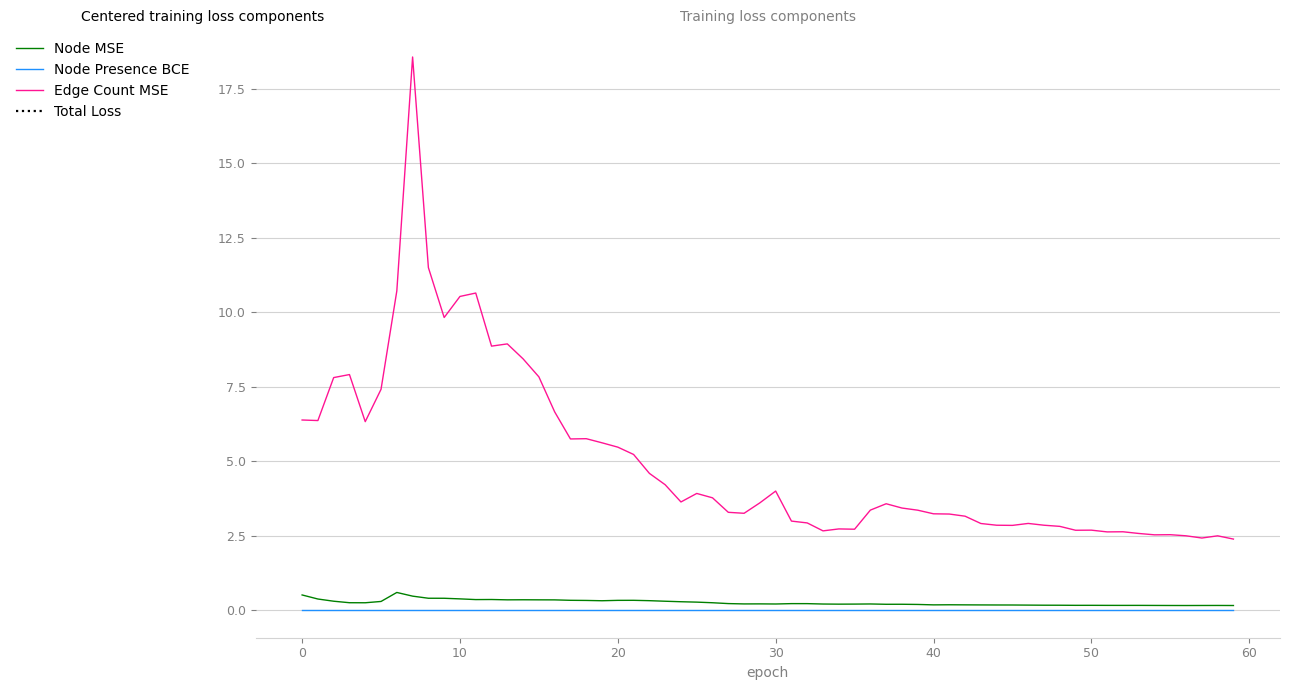

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Centered losses
losses_centered_total = np.array(normalized_total) - np.mean(normalized_total)
losses_centered_mse = np.array(normalized_mse) - np.mean(losses_mse)
losses_centered_presence = np.array(normalized_bce) - np.mean(normalized_bce)
losses_centered_edge = np.array(normalized_edge) - np.mean(normalized_edge)
losses_centered_mode = np.array(normalized_mode) - np.mean(normalized_mode)

# Create a 1x2 subplot layout
fig, axs = plt.subplots(
    1, 2,
    figsize=(13, 7),
    gridspec_kw={'width_ratios': [0, 1]}
)
# ── Left: Centered Losses ──

axs[0].plot(losses_centered_mse, **loss_plot_config["mse"])
axs[0].plot(losses_centered_presence, **loss_plot_config["presence"])
axs[0].plot(losses_centered_edge, **loss_plot_config["edge"])
# axs[0].plot(losses_centered_mode, **loss_plot_config["mode"])
axs[0].plot(losses_centered_total, **loss_plot_config["total"])
axs[0].set_xlabel("epoch", fontsize=10)
axs[0].set_ylabel("Loss (mean-centered)", fontsize=10)
axs[0].set_title("Centered training loss components", fontsize=10)
axs[0].legend(frameon=False)
axs[0].grid(True, color='lightgray')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].tick_params(labelsize=9)
axs[0].axis('off')  # Hide the left subplot


# ── Right: Raw Losses ──
alpha = 1
axs[1].plot(losses_mse, **loss_plot_config["mse"])
axs[1].plot(losses_presence, **loss_plot_config["presence"])
axs[1].plot(losses_edge, **loss_plot_config["edge"])


axs[1].set_xlabel("epoch", color='gray', fontsize=10)
axs[1].set_title("Training loss components", color='gray', fontsize=10)
axs[1].grid(axis='y', color='lightgray')

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].tick_params(labelsize=9, colors='gray' )
axs[1].spines['bottom'].set_color('lightgray')


plt.tight_layout()
plt.show()


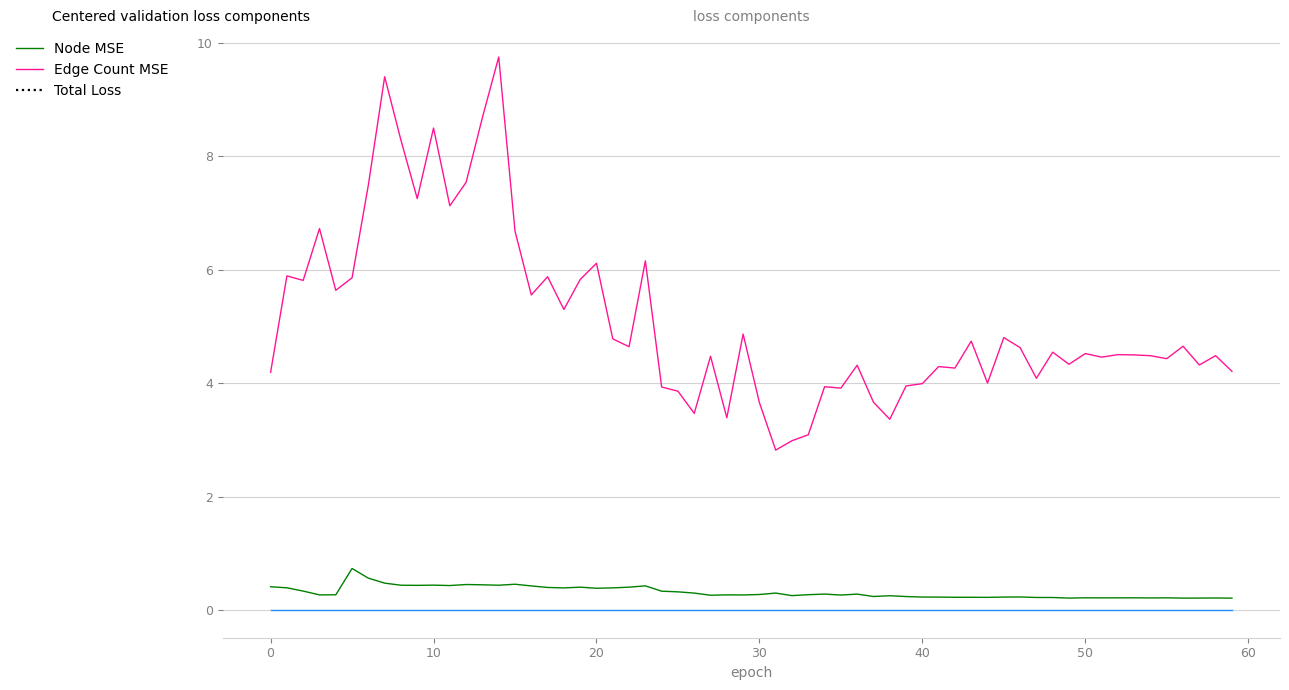

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Centered losses
losses_centered_mse = np.array(val_losses_mse) - np.mean(val_losses_mse)
losses_centered_presence = np.array(val_losses_presence) - np.mean(val_losses_presence)
losses_centered_edge = np.array(val_losses_edge) - np.mean(val_losses_edge)
losses_centered_mode = np.array(val_losses_mode) - np.mean(val_losses_mode)

# Create a 1x2 subplot layout
fig, axs = plt.subplots(
    1, 2,
    figsize=(13, 7),
    gridspec_kw={'width_ratios': [0, 1]}
)
# ── Left: Centered Losses ──

axs[0].plot(losses_centered_mse, **loss_plot_config["mse"])
axs[0].plot(losses_centered_edge, **loss_plot_config["edge"])
axs[0].plot(losses_centered_total, **loss_plot_config["total"])
axs[0].set_xlabel("epoch", fontsize=10)
axs[0].set_ylabel("Validation loss (mean-centered)", fontsize=10)
axs[0].set_title("Centered validation loss components", fontsize=10)
axs[0].legend(frameon=False)
axs[0].grid(True, color='lightgray')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].tick_params(labelsize=9)

axs[0].axis('off')  # Hide the left subplot

# ── Right: Raw Losses ──
alpha = 1
axs[1].plot(val_losses_mse, **loss_plot_config["mse"])
axs[1].plot(val_losses_presence, **loss_plot_config["presence"])
axs[1].plot(val_losses_edge, **loss_plot_config["edge"])


axs[1].set_xlabel("epoch", color='gray', fontsize=10)
axs[1].set_title("loss components", color='gray', fontsize=10)
axs[1].grid(axis='y', color='lightgray')

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].tick_params(labelsize=9, colors='gray' )
axs[1].spines['bottom'].set_color('lightgray')


plt.tight_layout()
plt.show()


In [284]:
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score
from scipy.stats import pearsonr

def evaluate_multitask(model, features, edge_indices, edge_features, targets, test_bins, bin_context, threshold=0.3):
    model.eval()
    node_true = []
    node_pred = []
    edge_true = []
    edge_pred = []
    mode_true = []
    mode_pred = []
    node_presence_true = []
    node_presence_pred = []

    with torch.no_grad():
        for t in test_bins:
            x_seq = features[t - window_size:t]
            ei_seq = edge_indices[t - window_size:t]
            ef_seq = edge_features[t - window_size:t]

            if all(ei.size(1) == 0 for ei in ei_seq):
                continue

            z = model.forward_encoder(x_seq, ei_seq, ef_seq)

            # Time context
            future_hour, future_day = bin_context[t]
            time_feat = torch.tensor([[future_hour, future_day]], dtype=torch.float)
            num_nodes = features[0].shape[0]
            node_time_feat = time_feat.repeat(num_nodes, 1)

            # ─── NODE PREDICTION ────────────────────────────────
            node_target = targets[t - 1][0]
            node_pred_t = model.predict_node_counts(z, node_time_feat)

            node_true.extend(node_target.cpu().numpy())
            node_pred.extend(node_pred_t.cpu().numpy())

            is_active = (node_target >= 1).float().cpu().numpy()
            p_active = count_to_probability(node_pred_t).cpu().numpy()
            predicted_active = (p_active >= threshold).astype(float)
            node_presence_true.extend(is_active)
            node_presence_pred.extend(predicted_active)

            # ─── EDGE PREDICTION ────────────────────────────────
            active_nodes = (node_pred_t >= threshold).nonzero(as_tuple=False).flatten()
            print(f"Active nodes at time {t}: {active_nodes.numel()}")
            if active_nodes.numel() == 0:
                continue

            df_prev = positions_links_df[positions_links_df["time_bin"] == t - 1]
            last_positions = (
                df_prev.sort_values("merged_datetime")
                       .groupby("id_participant")
                       .tail(1)
            )
            source_nodes = torch.tensor(last_positions["node_id"].unique(), dtype=torch.long)
            if source_nodes.numel() == 0: 
                continue

            from itertools import product
            source_to_active = list(product(source_nodes.tolist(), active_nodes.tolist()))
            active_to_active = list(product(active_nodes.tolist(), active_nodes.tolist()))
            all_candidate_pairs = list(set(source_to_active + active_to_active))
            candidate_edges = torch.tensor(all_candidate_pairs, dtype=torch.long).T

            edge_time_feat = time_feat.repeat(candidate_edges.shape[1], 1)

            true_edge_index = targets[t - 1][1]
            true_flow = targets[t - 1][2]
            true_mode = targets[t - 1][3]
            true_edge_dict = {tuple(e): i for i, e in enumerate(true_edge_index.T.tolist())}

            flow_targets = torch.tensor([
                true_flow[true_edge_dict[(int(s), int(d))]] if (int(s), int(d)) in true_edge_dict else 0.0
                for s, d in candidate_edges.T
            ], dtype=torch.float)

            exists_mask = torch.tensor([
                (int(s), int(d)) in true_edge_dict for s, d in candidate_edges.T
            ], dtype=torch.bool)

            if exists_mask.sum() > 0:
                valid_edges = candidate_edges[:, exists_mask]
                mode_targets = torch.tensor([ true_mode[true_edge_dict[(int(s), int(d))]] for s, d in valid_edges.T], dtype=torch.long)
                mode_logits = model.predict_edge_mode(z, valid_edges, time_feat.repeat(valid_edges.shape[1], 1))
                predicted_classes = mode_logits.argmax(dim=1)

                mode_true.extend(mode_targets.cpu().numpy())
                mode_pred.extend(predicted_classes.cpu().numpy())

            edge_pred_t = model.predict_edge_flow(z, candidate_edges, edge_time_feat)
            edge_true.extend(flow_targets.cpu().numpy())
            edge_pred.extend(edge_pred_t.cpu().numpy())

    # ─── METRICS ─────────────────────────────────────────────

    node_true = np.array(node_true)
    node_pred = np.array(node_pred)

    true_binary = np.array(node_presence_true)
    pred_binary = np.array(node_presence_pred)

    node_mse = mean_squared_error(node_true, node_pred) if len(node_true) > 0 else float('nan')
    edge_mse = mean_squared_error(edge_true, edge_pred) if len(edge_true) > 0 else float('nan')
    mode_acc = accuracy_score(mode_true, mode_pred) if len(mode_true) > 0 else float('nan')
    precision = precision_score(true_binary, pred_binary, zero_division=0) if len(true_binary) > 0 else float('nan')
    recall = recall_score(true_binary, pred_binary, zero_division=0) if len(true_binary) > 0 else float('nan')
    f1 = f1_score(true_binary, pred_binary, zero_division=0) if len(true_binary) > 0 else float('nan')
    accuracy = accuracy_score(true_binary, pred_binary) if len(true_binary) > 0 else float('nan')
    correlation = pearsonr(node_true, node_pred)[0] if len(node_true) > 1 else float('nan')

    print("\nEvaluation Results:")
    print(f"  ▪ Node Count MSE         : {node_mse:.4f}")
    print(f"  ▪ Edge Flow MSE          : {edge_mse:.4f}")
    print(f"  ▪ Transport Mode Accuracy: {mode_acc:.4f}")
    print(f"  ▪ Node Presence Accuracy : {accuracy:.4f}")
    print(f"  ▪ Node Precision         : {precision:.4f}")
    print(f"  ▪ Node Recall            : {recall:.4f}")
    print(f"  ▪ Node F1 Score          : {f1:.4f}")
    print(f"  ▪ Node Pearson Corr.     : {correlation:.4f}")

    results = {
        "node_mse": node_mse,
        "edge_mse": edge_mse,
        "mode_accuracy": mode_acc,
        "node_accuracy": accuracy,
        "node_precision": precision,
        "node_recall": recall,
        "node_f1": f1,
        "node_corr": correlation
    }

    return results


In [ ]:
metrics = evaluate_multitask(model, features, edge_indices, edge_features, targets, test_bins, bin_context)

Active nodes at time 108: 5
Active nodes at time 109: 5
Active nodes at time 110: 5
Active nodes at time 111: 5
Active nodes at time 112: 5
Active nodes at time 113: 5
Active nodes at time 114: 5
Active nodes at time 115: 5
Active nodes at time 116: 5
Active nodes at time 117: 5
Active nodes at time 118: 5
Active nodes at time 119: 5
Active nodes at time 228: 9
Active nodes at time 229: 5
Active nodes at time 230: 5
Active nodes at time 231: 5
Active nodes at time 232: 5
Active nodes at time 233: 9
Active nodes at time 234: 11
Active nodes at time 235: 15
Active nodes at time 236: 9
Active nodes at time 237: 12
Active nodes at time 238: 8
Active nodes at time 239: 10
Active nodes at time 348: 5
Active nodes at time 349: 1
Active nodes at time 350: 2
Active nodes at time 351: 1
Active nodes at time 352: 1
Active nodes at time 353: 1
Active nodes at time 354: 1
Active nodes at time 355: 1
Active nodes at time 356: 1
Active nodes at time 357: 1
Active nodes at time 358: 1
Active nodes at 

In [ ]:
if USE_CLIMATE_FEATURES and USE_URBAN_FEATURES:
    model_name = "gnn_climate_urban"
elif USE_CLIMATE_FEATURES:
    model_name = "gnn_climate"
elif USE_URBAN_FEATURES:
    model_name = "gnn_urban"
else:
    model_name = "gnn_baseline"

save_path = os.path.join(BASE_DIR, f"Results/models/{model_name}.pth")


torch.save({
    "epoch": num_epochs,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "train_losses": {
        "total": losses_total,
        "mse": losses_mse,
        "edge": losses_edge,
        "presence": losses_presence,
        "mode": losses_mode,
    },
    "val_losses": {
        "total": val_losses_total,
        "mse": val_losses_mse,
        "edge": val_losses_edge,
        "presence": val_losses_presence,
        "mode": val_losses_mode,
    },
    "metrics": metrics,
    "config": {
        "window_size": window_size,
        "embedding_dim": embedding_dim,
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "use_climate": USE_CLIMATE_FEATURES,
        "use_urban": USE_URBAN_FEATURES,
        "using_intersection_node_type": USING_INTERSECTION_NODE_TYPE,
    }
}, save_path)

In [ ]:
artifacts_path = os.path.join(BASE_DIR, f"Results/models/{model_name}_dataset_artifacts.pt")
torch.save({
    "features": features,
    "edge_indices": edge_indices,
    "edge_features": edge_features,
    "targets": targets,
    "bin_context": bin_context,
    "window_size": window_size,
    "test_bins": test_bins,
    "val_bins": val_bins,
    "train_bins": train_bins,
    "start_time_dt": start_time_dt,   
    "interval": interval,             
}, artifacts_path)
print(f"Saved dataset artifacts to: {artifacts_path}")

Saved dataset artifacts to: D:/Desktop/MSc Thesis/Results/models/gnn_climate_urban_dataset_artifacts.pt
